In [1]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

Using MPI version 3.1, 1 processes


In [2]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set=400         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=frq_cs/20          # frequency width

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53
    #---source I
    nfreq2 = 100
    fmin2 = 1/1.45
    fmax2 = 1/1.6

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.GaussianSource(frq_cs, fwidth=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)
    dx=1/resolution
    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - dx)))
    trans_ref2 = sim.add_flux(0.5 * (fmin2 + fmax2), fmax2 - fmin2, nfreq2,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - dx)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))

    #         Define E field monitor
    dt=0.5*dx
    tm_val_x=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,0), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    tm_val_x=np.array(tm_val_x)
    max_ind=np.size(tm_val_x)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)
    #         Save reference data2
    freqs_ref2 = mp.get_flux_freqs(trans_ref2)
    plt_range_ref2=1/np.asarray(freqs_ref2)
    box_x1_trans_ref2 = mp.get_fluxes(trans_ref2)
    flux_ref2=np.asarray(box_x1_trans_ref2)
    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - dx)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + dx)))

    sim.run(until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - dx)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + dx)))

    sim.run(until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    E_out=np.amax(tm_val_x)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref

    figure2=plt.figure(dpi=100)
    ax1=plt.subplot(1, 2, 1)
    plt.plot(mon_t,tm_val_x/(10**-6))
    plt.xlabel('time (fs)')
    plt.ylabel('Ex (V/m)') 
    ax2=plt.subplot(1, 2, 2)
    plt.plot(plt_range_ref2,flux_ref2,'b-',label='T')
    plt.grid(True,which="both",ls="-")
    plt.xlabel('Wavelength, um')
    plt.ylabel('I, W/um^2')
    plt.legend(loc='upper right')
    plt.title('Source intensity')
    plt.tight_layout()

    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l, flux_ref

0
-----------
Initializing structure...
time for choose_chunkdivision = 6.79493e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000227928 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 285.1277777777778/400.0 = 71.3% done in 4.0s, 1.6s to go
on time step 51421 (time=285.672), 7.77904e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000287056 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000259161 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
1749406.3763242208
[0.94239347]
[0.05760638]
[1.55665441e-07]
[0.94238413]
[0.05761587]
[-8.24895707e-14]
[1.53]
1
-----------
Initializing structure...
time for choose_chunkdivision = 7.10487e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000226021 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 319.35/400.0 = 79.8% done in 4.0s, 1.0s to go
on time step 57548 (time=319.711), 6.95074e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00026083 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000261784 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
19418410.777198844
[0.94352381]
[0.05644773]
[2.84532749e-05]
[0.94238413]
[0.05761587]
[-6.63913369e-14]
[1.53]
2
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216961 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 332.56666666666666/400.0 = 83.1% done in 4.0s, 0.8s to go
on time step 59929 (time=332.939), 6.67459e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262976 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272989 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
37087415.1780734
[0.94643005]
[0.05337218]
[0.00019776]
[0.94238413]
[0.05761587]
[-6.19504448e-14]
[1.53]
3
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.00022006 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 329.5055555555556/400.0 = 82.4% done in 4.0s, 0.9s to go
on time step 59381 (time=329.894), 6.73618e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257969 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000265121 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
54756419.578948095
[0.95077002]
[0.0484412]
[0.00078878]
[0.94238413]
[0.05761587]
[-9.41469125e-14]
[1.53]
4
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216961 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 330.95/400.0 = 82.7% done in 4.0s, 0.8s to go
on time step 59646 (time=331.367), 6.70628e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000277042 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262022 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
72425423.97982264
[0.95586816]
[0.04180309]
[0.00232875]
[0.94238413]
[0.05761587]
[-7.61612995e-14]
[1.53]
5
-----------
Initializing structure...
time for choose_chunkdivision = 8.4877e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000272036 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 302.0777777777778/400.0 = 75.5% done in 4.0s, 1.3s to go
on time step 54429 (time=302.383), 7.34913e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272036 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000275135 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
90094428.38069732
[0.96058865]
[0.03377146]
[0.00563989]
[0.94238413]
[0.05761587]
[-7.76045894e-14]
[1.53]
6
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000224113 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 300.18333333333334/400.0 = 75.0% done in 4.0s, 1.3s to go
on time step 54109 (time=300.606), 7.39249e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.19888e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000295877 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000348091 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
107763432.7815718
[0.96334949]
[0.02492546]
[0.01172504]
[0.94238413]
[0.05761587]
[-7.53841434e-14]
[1.53]
7
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000236988 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 313.56666666666666/400.0 = 78.4% done in 4.0s, 1.1s to go
on time step 56517 (time=313.983), 7.07775e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000105143 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000263929 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
125432437.18244646
[0.96250921]
[0.01616015]
[0.02133063]
[0.94238413]
[0.05761587]
[-8.23785484e-14]
[1.53]
8
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000218868 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 290.14444444444445/400.0 = 72.5% done in 4.0s, 1.5s to go
on time step 52299 (time=290.55), 7.64833e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000271082 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000265837 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
143101441.583321
[0.95704204]
[0.00858445]
[0.03437351]
[0.94238413]
[0.05761587]
[-7.12763182e-14]
[1.53]
9
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000217915 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 323.2611111111111/400.0 = 80.8% done in 4.0s, 0.9s to go
on time step 58275 (time=323.75), 6.86408e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.08375e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000268936 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00026679 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
160770445.984196
[0.94673274]
[0.00328409]
[0.04998317]
[0.94238413]
[0.05761587]
[-7.4162898e-14]
[1.53]
10
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000221014 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 325.80555555555554/400.0 = 81.5% done in 4.0s, 0.9s to go
on time step 58743 (time=326.35), 6.80941e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000263929 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
178439450.3850707
[0.93152015]
[0.00112258]
[0.06735727]
[0.94238413]
[0.05761587]
[-6.33937347e-14]
[1.53]
11
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000250816 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 317.4111111111111/400.0 = 79.4% done in 4.0s, 1.0s to go
on time step 57215 (time=317.861), 6.99119e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262976 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
196108454.7859451
[0.91127623]
[0.00261154]
[0.08611224]
[0.94238413]
[0.05761587]
[-6.42819131e-14]
[1.53]
12
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000285864 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 307.95/400.0 = 77.0% done in 4.0s, 1.2s to go
on time step 55479 (time=308.217), 7.20996e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.50883e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000277042 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000266075 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
213777459.18681946
[0.88640501]
[0.00780246]
[0.10579253]
[0.94238413]
[0.05761587]
[-8.90398866e-14]
[1.53]
13
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000236034 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 314.18333333333334/400.0 = 78.5% done in 4.0s, 1.1s to go
on time step 56617 (time=314.539), 7.06502e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000261784 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000266075 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
231446463.58769462
[0.85782313]
[0.01631239]
[0.12586448]
[0.94238413]
[0.05761587]
[-9.12603326e-14]
[1.53]
14
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216961 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 321.56666666666666/400.0 = 80.4% done in 4.0s, 1.0s to go
on time step 57957 (time=321.983), 6.90175e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000267029 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264883 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
249115467.98856923
[0.82615765]
[0.02747627]
[0.14636608]
[0.94238413]
[0.05761587]
[-6.94999613e-14]
[1.53]
15
-----------
Initializing structure...
time for choose_chunkdivision = 7.00951e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000218868 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 332.5444444444445/400.0 = 83.1% done in 4.0s, 0.8s to go
on time step 59935 (time=332.972), 6.67416e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000258923 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000258923 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
266784472.3894433
[0.79215238]
[0.04052374]
[0.16732387]
[0.94238413]
[0.05761587]
[-9.65894031e-14]
[1.53]
16
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.00022006 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 316.83333333333337/400.0 = 79.2% done in 4.0s, 1.0s to go
on time step 57088 (time=317.156), 7.00678e-05 s/step
run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000265121 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000261068 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

run 0 finished at t = 400.0 (72000 timesteps)
284453476.7903182
[0.75691448]
[0.05472807]
[0.18835746]
[0.94238413]
[0.05761587]
[-9.55902024e-14]
[1.53]


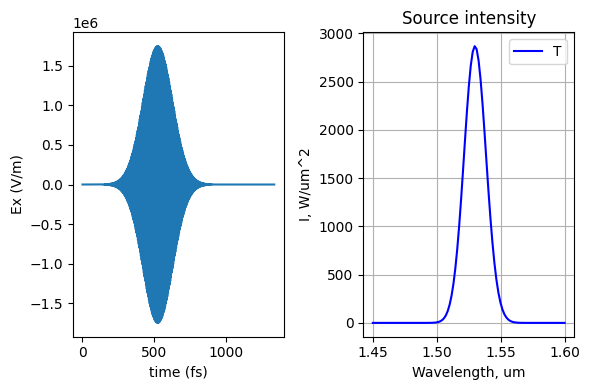

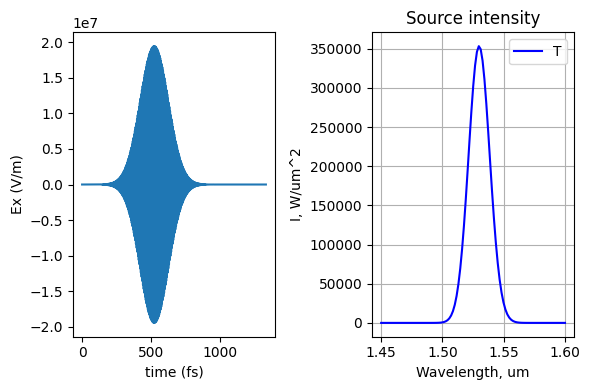

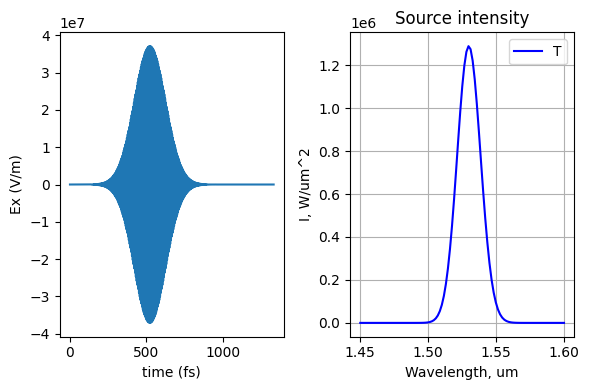

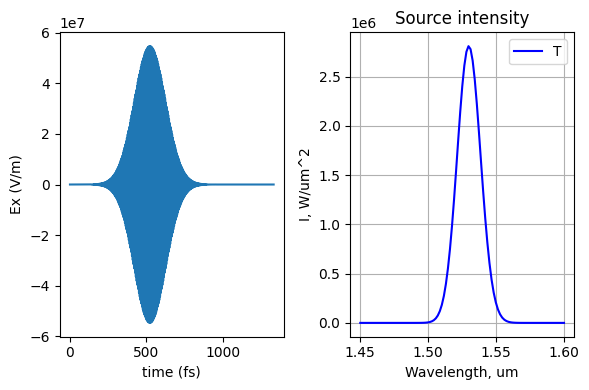

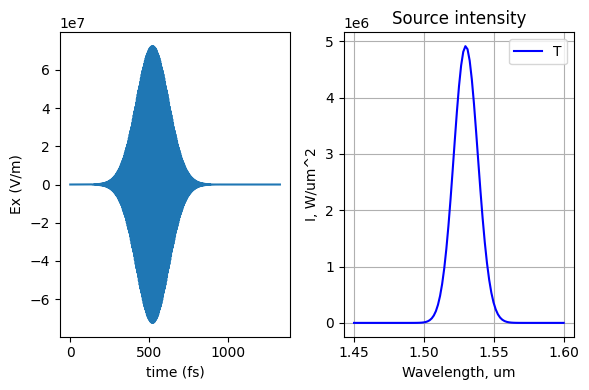

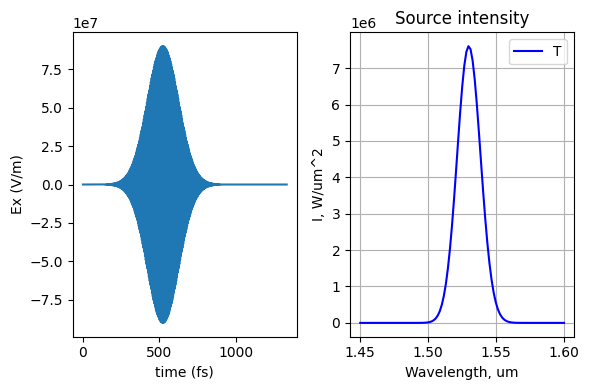

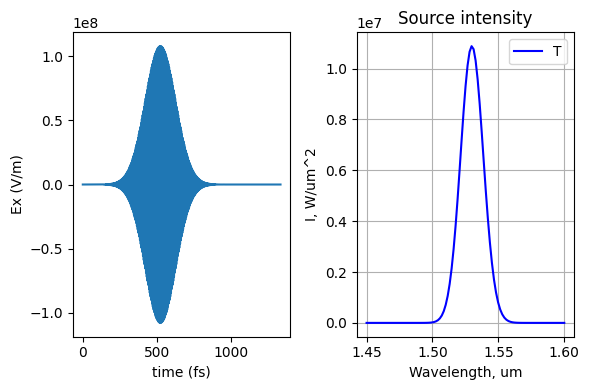

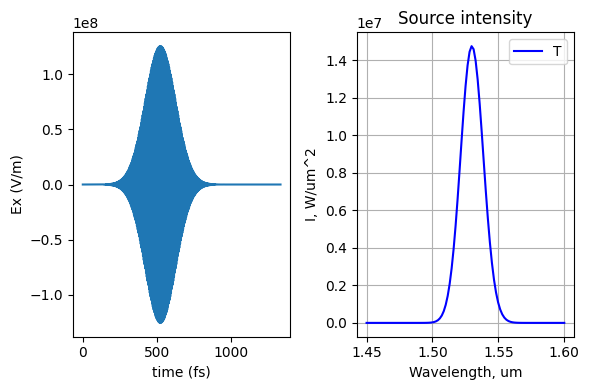

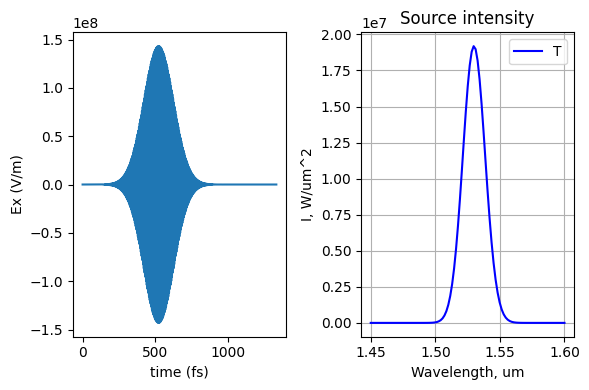

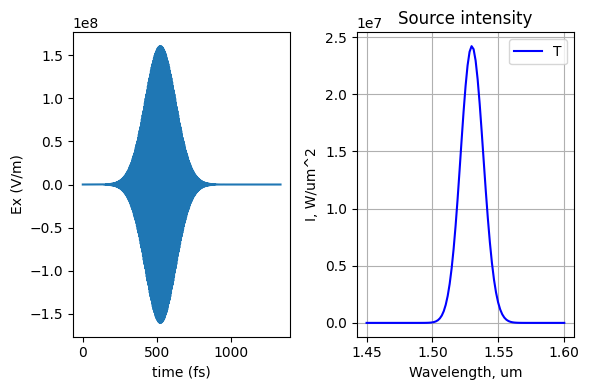

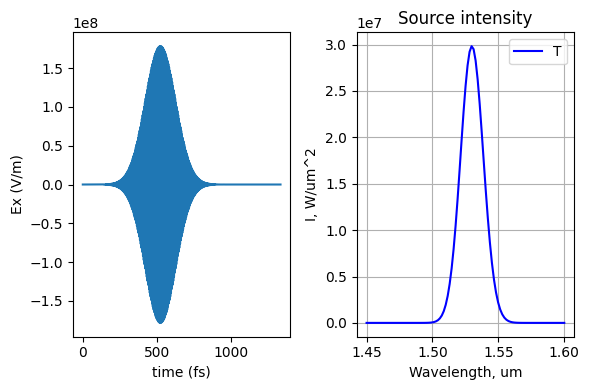

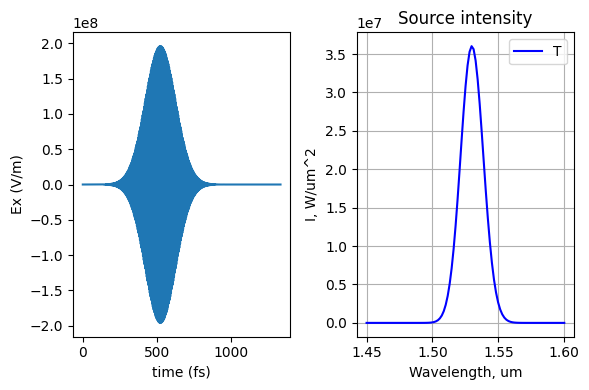

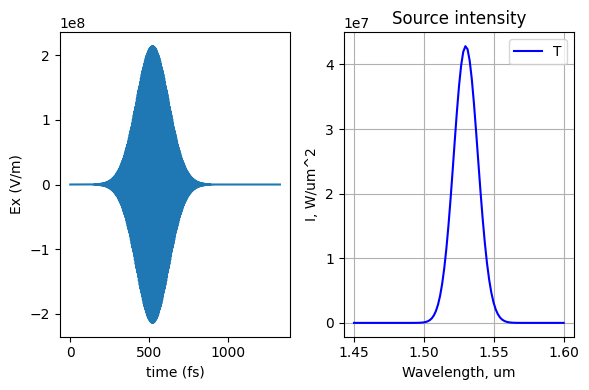

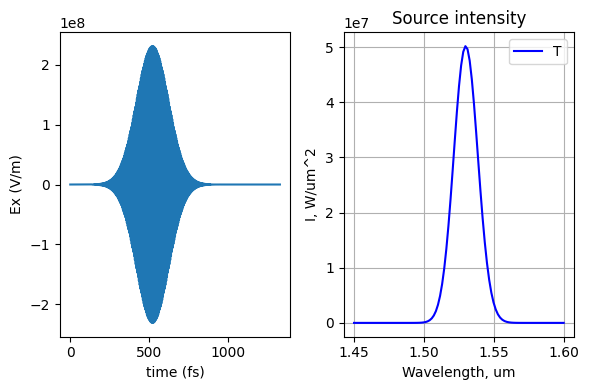

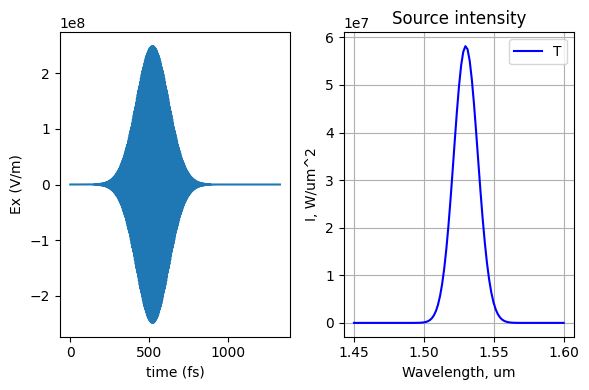

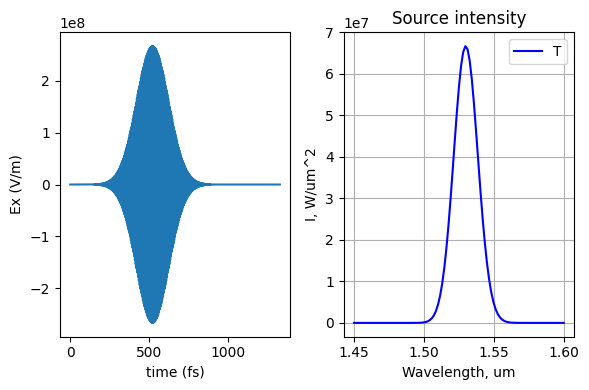

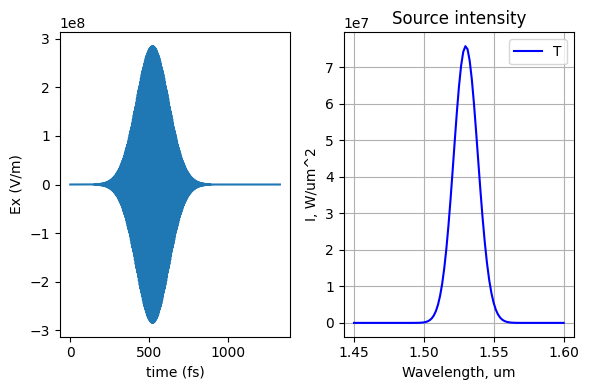

In [3]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
flux_ref = np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j], flux_ref[j] = nl_cw(amp[j],resolution,k,n)

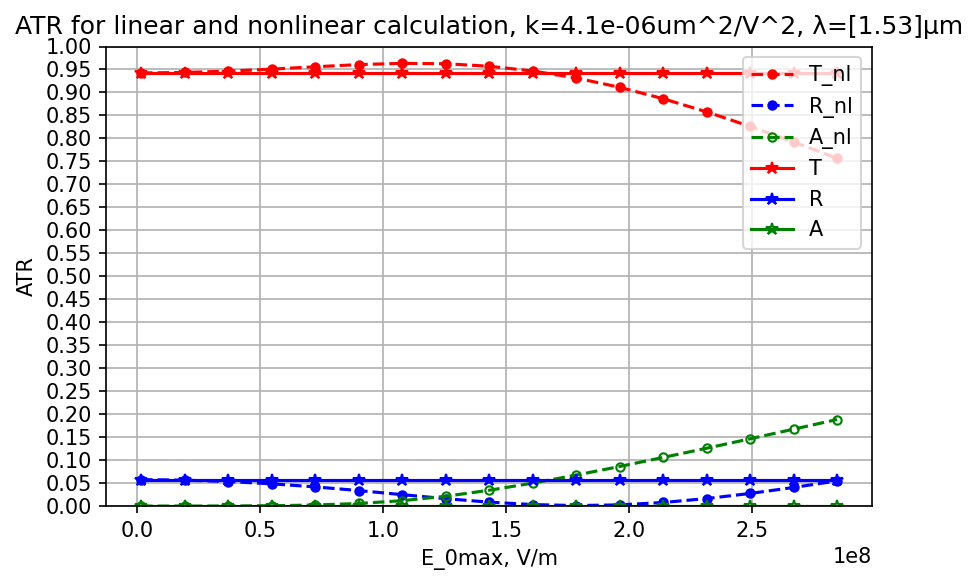

In [4]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0max, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

No handles with labels found to put in legend.


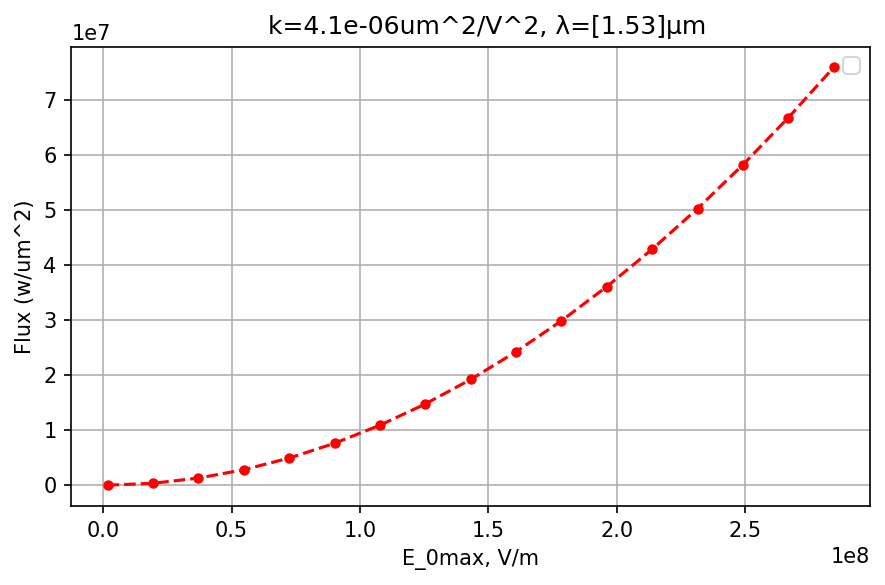

In [5]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,flux_ref,'ro--',markersize=4)
plt.grid(True,which="both",ls="-")
plt.xlabel('E_0max, V/m')
plt.ylabel('Flux (w/um^2)')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.title('    k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()